<a href="https://colab.research.google.com/github/KarlaLutz/Trabalho_Cripto_Turma9_BigData_FGV/blob/main/Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importação de Pacotes**

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pickle
from simple_robot import feature_eng
from sklearn.ensemble import RandomForestRegressor

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale

import matplotlib.pyplot as plt
from matplotlib import rcParams
from pylab import rcParams

import seaborn as sb
import seaborn as sns
import scipy
from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import scale

# Baixando os dados de BITCOIN
df = pd.read_parquet('https://drive.google.com/u/0/uc?id=1K1-mXTk426z8ZvbmWrx8zrbC-C6GxxGg&export=download')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Ajuste do Data Frame**

In [3]:
# Importando os dados do dataframe com as features adicionais
import io
import requests

url="https://raw.githubusercontent.com/xirusmore/MBA/master/btc_social_02.csv"
s=requests.get(url).content
df_add=pd.read_csv(io.StringIO(s.decode('utf-8')), sep=';', decimal='.')

In [4]:
# Função para converter a hora da transação em hora cheia 
def add_hora_cheia (row):
   return pd.Timestamp(year = row.datetime.year,  
                     month = row.datetime.month, 
                     day = row.datetime.day, 
                     hour = row.datetime.hour, 
                     second = 0)

In [5]:
# Adicionando nova coluna com a hora cheia
df['hora_cheia'] = df.apply (lambda row: add_hora_cheia(row), axis=1)
df['open_time'] = df.index.to_pydatetime()

In [6]:
df.head()

,symbol,datetime,close_time,open,high,low,close,volume,number_of_trades,hora_cheia,open_time
open_time,,,,,,,,,,,
2017-08-17 04:00:00,BTCUSDT,2017-08-17 04:00:00,1502942459999,4261.479980,4261.479980,4261.479980,4261.479980,1.775183,3,2017-08-17 04:00:00,2017-08-17 04:00:00
2017-08-17 04:01:00,BTCUSDT,2017-08-17 04:01:00,1502942519999,4261.479980,4261.479980,4261.479980,4261.479980,0.000000,0,2017-08-17 04:00:00,2017-08-17 04:01:00
2017-08-17 04:02:00,BTCUSDT,2017-08-17 04:02:00,1502942579999,4280.560059,4280.560059,4280.560059,4280.560059,0.261074,2,2017-08-17 04:00:00,2017-08-17 04:02:00
2017-08-17 04:03:00,BTCUSDT,2017-08-17 04:03:00,1502942639999,4261.479980,4261.479980,4261.479980,4261.479980,0.012008,3,2017-08-17 04:00:00,2017-08-17 04:03:00
2017-08-17 04:04:00,BTCUSDT,2017-08-17 04:04:00,1502942699999,4261.479980,4261.479980,4261.479980,4261.479980,0.140796,1,2017-08-17 04:00:00,2017-08-17 04:04:00


In [7]:
# Transformando a coluna time do data frame com as features adicionais em timestamp

df_add['hora_cheia'] = df_add.apply (lambda row: pd.to_datetime(row.time, unit='s'), axis=1)

In [8]:
df_add.head()

,asset_id,time,open,close,high,low,volume,market_cap,url_shares,unique_url_shares,reddit_posts,reddit_posts_score,reddit_comments,reddit_comments_score,tweets,tweet_spam,tweet_followers,tweet_quotes,tweet_retweets,tweet_replies,tweet_favorites,tweet_sentiment1,tweet_sentiment2,tweet_sentiment3,tweet_sentiment4,tweet_sentiment5,tweet_sentiment_impact1,tweet_sentiment_impact2,tweet_sentiment_impact3,tweet_sentiment_impact4,tweet_sentiment_impact5,social_score,average_sentiment,sentiment_absolute,sentiment_relative,search_average,news,price_score,social_impact_score,correlation_rank,galaxy_score,volatility,alt_rank,alt_rank_30d,market_cap_rank,percent_change_24h_rank,volume_24h_rank,social_volume_24h_rank,social_score_24h_rank,medium,youtube,social_contributors,social_volume,price_btc,social_volume_global,social_dominance,market_cap_global,market_dominance,hora_cheia
0,1,1567468800,10406.81,10625.10,10773.27,10296.30,NaN,1.910000e+11,74.0,74.0,12.0,69.0,36.0,170.0,41402.0,4413.0,NaN,NaN,NaN,NaN,NaN,1837.0,3112.0,6798.0,23186.0,2055.0,36752522.0,21825007.0,50415744.0,193422913.0,18600351.0,321030863.0,3.6,NaN,NaN,53.0,314.0,1.0,2.0,4.0,53.0,0.740612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41838,1,NaN,NaN,NaN,NaN,2019-09-03
1,1,1567555200,10589.31,10585.20,10827.14,10392.88,NaN,1.900000e+11,65.0,65.0,9.0,90.0,38.0,102.0,36533.0,4053.0,NaN,NaN,NaN,NaN,NaN,1706.0,2686.0,6784.0,19516.0,1788.0,27579525.0,24287817.0,59267151.0,139490090.0,13762747.0,264399710.0,3.5,NaN,NaN,53.0,280.0,1.0,2.0,5.0,57.5,0.528566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36925,1,NaN,NaN,NaN,NaN,2019-09-04
2,1,1567641600,10534.67,10556.16,10659.60,10475.88,NaN,1.900000e+11,59.0,59.0,9.0,105.0,33.0,120.0,36489.0,3544.0,NaN,NaN,NaN,NaN,NaN,1566.0,2653.0,6810.0,20120.0,1796.0,7970967.0,12998972.0,55743080.0,147163614.0,13180288.0,237067039.0,3.5,NaN,NaN,51.0,250.0,1.0,4.0,5.0,67.5,0.178502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36840,1,NaN,NaN,NaN,NaN,2019-09-05
3,1,1567728000,10564.49,10309.91,10938.39,10228.17,NaN,1.860000e+11,67.0,67.0,7.0,18.0,47.0,200.0,39406.0,3587.0,NaN,NaN,NaN,NaN,NaN,1970.0,2808.0,7385.0,21555.0,2101.0,6142248.0,25172342.0,40381925.0,158676849.0,17997002.0,248382031.0,3.5,NaN,NaN,52.0,244.0,3.1,4.0,5.0,78.0,0.212571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39771,1,NaN,NaN,NaN,NaN,2019-09-06
4,1,1567814400,10340.02,10491.96,10574.99,10331.88,NaN,1.880000e+11,44.0,44.0,4.0,13.0,37.0,136.0,30199.0,3848.0,NaN,NaN,NaN,NaN,NaN,1184.0,2189.0,5811.0,15538.0,1629.0,8514505.0,13963143.0,33175351.0,102901931.0,13110198.0,171672628.0,3.5,NaN,NaN,48.0,1.0,5.0,4.0,5.0,87.5,0.367695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30285,1,NaN,NaN,NaN,NaN,2019-09-07


In [9]:
# Deixando apenas as colunas com as features que iremos usar (manter sempre 'hora_cheia', pois é a chave do join)

df_add = df_add[['hora_cheia','url_shares','reddit_posts','reddit_posts_score','reddit_comments_score','tweet_quotes','tweet_retweets','tweet_replies','tweet_sentiment_impact3','average_sentiment','news','price_score','social_impact_score','correlation_rank','volatility','alt_rank','market_cap_rank','percent_change_24h_rank','volume_24h_rank','social_volume_24h_rank','social_dominance']]
df_add.head(5)

,hora_cheia,url_shares,reddit_posts,reddit_posts_score,reddit_comments_score,tweet_quotes,tweet_retweets,tweet_replies,tweet_sentiment_impact3,average_sentiment,news,price_score,social_impact_score,correlation_rank,volatility,alt_rank,market_cap_rank,percent_change_24h_rank,volume_24h_rank,social_volume_24h_rank,social_dominance
0,2019-09-03,74.0,12.0,69.0,170.0,NaN,NaN,NaN,50415744.0,3.6,314.0,1.0,2.0,4.0,0.740612,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-09-04,65.0,9.0,90.0,102.0,NaN,NaN,NaN,59267151.0,3.5,280.0,1.0,2.0,5.0,0.528566,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-09-05,59.0,9.0,105.0,120.0,NaN,NaN,NaN,55743080.0,3.5,250.0,1.0,4.0,5.0,0.178502,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-09-06,67.0,7.0,18.0,200.0,NaN,NaN,NaN,40381925.0,3.5,244.0,3.1,4.0,5.0,0.212571,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-09-07,44.0,4.0,13.0,136.0,NaN,NaN,NaN,33175351.0,3.5,1.0,5.0,4.0,5.0,0.367695,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Realizando join dos dois dataframes
df_full = pd.merge(df, df_add, how='left',  on = 'hora_cheia')
df_full = df_full.set_index('open_time')
df_full.head(5)

,symbol,datetime,close_time,open,high,low,close,volume,number_of_trades,hora_cheia,url_shares,reddit_posts,reddit_posts_score,reddit_comments_score,tweet_quotes,tweet_retweets,tweet_replies,tweet_sentiment_impact3,average_sentiment,news,price_score,social_impact_score,correlation_rank,volatility,alt_rank,market_cap_rank,percent_change_24h_rank,volume_24h_rank,social_volume_24h_rank,social_dominance
open_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-17 04:00:00,BTCUSDT,2017-08-17 04:00:00,1502942459999,4261.479980,4261.479980,4261.479980,4261.479980,1.775183,3,2017-08-17 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 04:01:00,BTCUSDT,2017-08-17 04:01:00,1502942519999,4261.479980,4261.479980,4261.479980,4261.479980,0.000000,0,2017-08-17 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 04:02:00,BTCUSDT,2017-08-17 04:02:00,1502942579999,4280.560059,4280.560059,4280.560059,4280.560059,0.261074,2,2017-08-17 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 04:03:00,BTCUSDT,2017-08-17 04:03:00,1502942639999,4261.479980,4261.479980,4261.479980,4261.479980,0.012008,3,2017-08-17 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 04:04:00,BTCUSDT,2017-08-17 04:04:00,1502942699999,4261.479980,4261.479980,4261.479980,4261.479980,0.140796,1,2017-08-17 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# **Calculando o target (y)**

In [11]:
# Calculando qual a média de close dos próximos 10min
df_full['forward_average'] = df_full[::-1]['close'].rolling(10).mean()[::-1].shift(-1)

# Target será a diferença percentual do 'forward_average' com o 'close' atual 
df_full['target'] = 100*(df_full['forward_average'] - df_full['close']) / df_full['close']

df_full.head(3)
# Outra possibilidade: target como a diferença entre o proximo minuto e o atual: df['diff']= -df['close'].diff(-1)

,symbol,datetime,close_time,open,high,low,close,volume,number_of_trades,hora_cheia,url_shares,reddit_posts,reddit_posts_score,reddit_comments_score,tweet_quotes,tweet_retweets,tweet_replies,tweet_sentiment_impact3,average_sentiment,news,price_score,social_impact_score,correlation_rank,volatility,alt_rank,market_cap_rank,percent_change_24h_rank,volume_24h_rank,social_volume_24h_rank,social_dominance,forward_average,target
open_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-17 04:00:00,BTCUSDT,2017-08-17 04:00:00,1502942459999,4261.479980,4261.479980,4261.479980,4261.479980,1.775183,3,2017-08-17 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4263.387988,0.044773
2017-08-17 04:01:00,BTCUSDT,2017-08-17 04:01:00,1502942519999,4261.479980,4261.479980,4261.479980,4261.479980,0.000000,0,2017-08-17 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4263.387988,0.044773
2017-08-17 04:02:00,BTCUSDT,2017-08-17 04:02:00,1502942579999,4280.560059,4280.560059,4280.560059,4280.560059,0.261074,2,2017-08-17 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4261.479980,-0.445738


# **Calculando as features (x)**

In [12]:
# Toda a parte de criação de features está no arquivo simple_robot.py. Aqui apenas chamamos a função. Isso é útil, pois conseguimos usar a mesma função no momento de colocar o robô em produçã

df_full = feature_eng(df_full)
df_full.head(5)

,const,close,volume,number_of_trades,url_shares,reddit_posts,reddit_posts_score,reddit_comments_score,tweet_quotes,tweet_retweets,tweet_replies,tweet_sentiment_impact3,average_sentiment,news,price_score,social_impact_score,correlation_rank,volatility,alt_rank,market_cap_rank,percent_change_24h_rank,volume_24h_rank,social_volume_24h_rank,social_dominance,target,lag_1,lag_2,ma_10,ma_30,ratio_ma,time
open_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-07 23:00:00,1.0,8242.259766,34.881321,357,861.0,15.0,359.0,156.0,20.0,288.0,148.0,1979606.0,3.7,4.0,2.5,2.8,4.9,0.021374,35.0,1.0,629.0,2.0,1.0,35.735403,-0.008550,0.143281,0.169489,8225.729980,8214.586328,1.001357,135991
2019-10-07 23:01:00,1.0,8236.400391,45.871037,364,861.0,15.0,359.0,156.0,20.0,288.0,148.0,1979606.0,3.7,4.0,2.5,2.8,4.9,0.021374,35.0,1.0,629.0,2.0,1.0,35.735403,0.076327,-0.071140,0.072243,8227.960059,8215.296680,1.001541,135992
2019-10-07 23:02:00,1.0,8234.250000,18.871227,263,861.0,15.0,359.0,156.0,20.0,288.0,148.0,1979606.0,3.7,4.0,2.5,2.8,4.9,0.021374,35.0,1.0,629.0,2.0,1.0,35.735403,0.117327,-0.026115,-0.097274,8229.686035,8215.921029,1.001675,135993
2019-10-07 23:03:00,1.0,8239.610352,33.930275,422,861.0,15.0,359.0,156.0,20.0,288.0,148.0,1979606.0,3.7,4.0,2.5,2.8,4.9,0.021374,35.0,1.0,629.0,2.0,1.0,35.735403,0.062547,0.065056,0.038958,8232.245117,8216.901693,1.001867,135994
2019-10-07 23:04:00,1.0,8240.500000,24.455221,339,861.0,15.0,359.0,156.0,20.0,288.0,148.0,1979606.0,3.7,4.0,2.5,2.8,4.9,0.021374,35.0,1.0,629.0,2.0,1.0,35.735403,0.063139,0.010796,0.075845,8234.425098,8217.933366,1.002007,135995


In [13]:
df_full.isnull().sum()

const                      0
close                      0
volume                     0
number_of_trades           0
url_shares                 0
reddit_posts               0
reddit_posts_score         0
reddit_comments_score      0
tweet_quotes               0
tweet_retweets             0
tweet_replies              0
tweet_sentiment_impact3    0
average_sentiment          0
news                       0
price_score                0
social_impact_score        0
correlation_rank           0
volatility                 0
alt_rank                   0
market_cap_rank            0
percent_change_24h_rank    0
volume_24h_rank            0
social_volume_24h_rank     0
social_dominance           0
target                     0
lag_1                      0
lag_2                      0
ma_10                      0
ma_30                      0
ratio_ma                   0
time                       0
dtype: int64

In [14]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 927577 entries, 2019-10-07 23:00:00 to 2021-07-24 00:59:00
Data columns (total 31 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   const                    927577 non-null  float64
 1   close                    927577 non-null  float32
 2   volume                   927577 non-null  float32
 3   number_of_trades         927577 non-null  uint16 
 4   url_shares               927577 non-null  float64
 5   reddit_posts             927577 non-null  float64
 6   reddit_posts_score       927577 non-null  float64
 7   reddit_comments_score    927577 non-null  float64
 8   tweet_quotes             927577 non-null  float64
 9   tweet_retweets           927577 non-null  float64
 10  tweet_replies            927577 non-null  float64
 11  tweet_sentiment_impact3  927577 non-null  float64
 12  average_sentiment        927577 non-null  float64
 13  news                     

In [15]:
features = df_full[[
      'close',
      'volume',
      'number_of_trades',
      'url_shares',
      'reddit_posts',
      'reddit_posts_score',
      'reddit_comments_score',
      'tweet_quotes',
      'tweet_retweets',
      'tweet_replies',
      'tweet_sentiment_impact3',
      'average_sentiment',
      'news',
      'price_score',
      'social_impact_score',
      'correlation_rank',
      'volatility',
      'alt_rank',
      'market_cap_rank',
      'percent_change_24h_rank',
      'volume_24h_rank',
      'social_volume_24h_rank',
      'social_dominance',
      'target',
      'lag_1',
      'lag_2',
      'ma_10',
      'ma_30',
      'ratio_ma',
      'time'              
]]

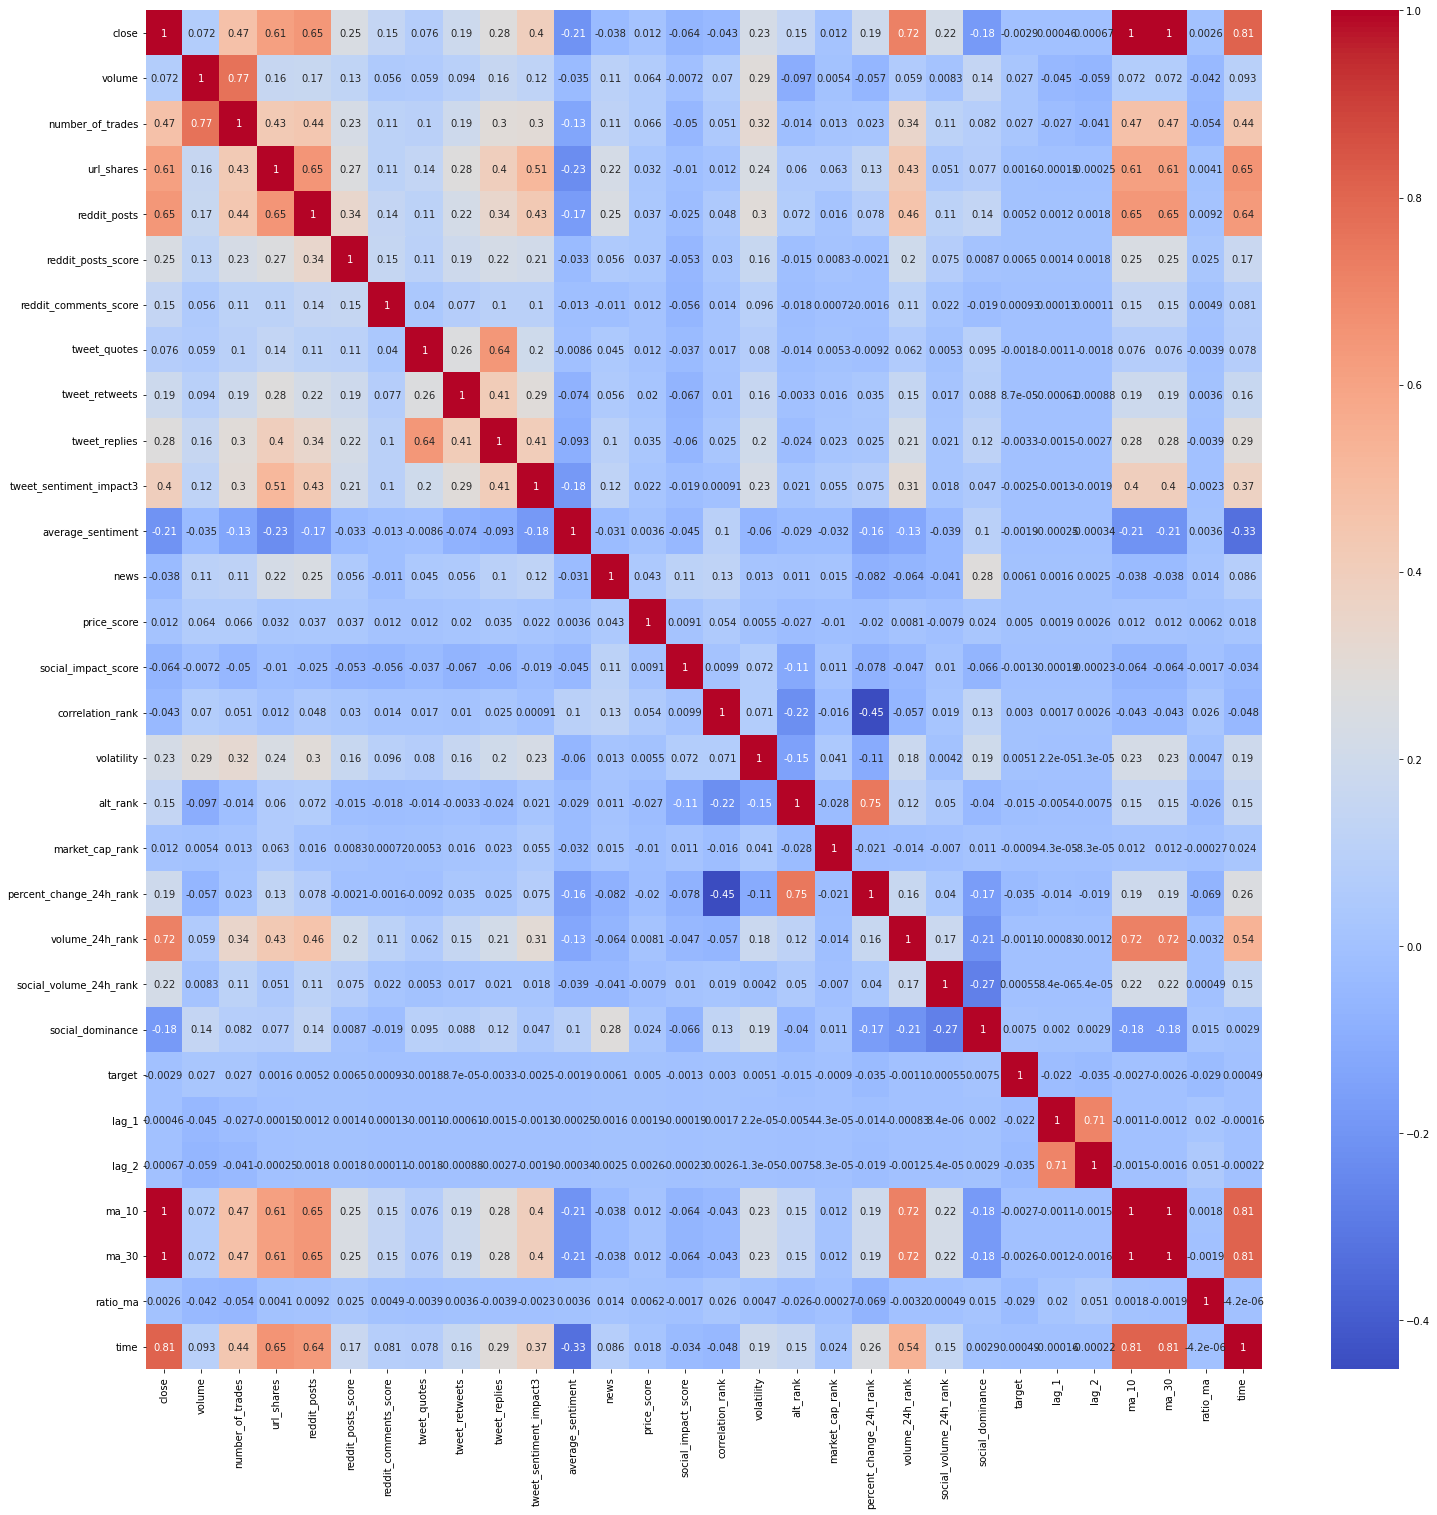

In [16]:
fig = plt.figure(figsize=(25,25))
sns.heatmap(features.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')
plt.show()

A lista definitva dos features escolhidos para montar nosso modelo sao as presentes na matriz de correlacao de acima. Alem destes features tambem testamos adicionar outros como "weeknum", "weekday" e "hour". Mas quando adicionamos eles no dataframe final, estes nao impactaram a performance do modelo (modelo aqui em baixo). Entao, decidimos nao considerar eles e deixar um modelo mais "enchuto".

# **Separando em treino/teste**

In [17]:
test_treshold = '2021-06-01 00:00:00'

train = df_full[df_full.index <= test_treshold]
test = df_full[df_full.index > test_treshold]

X_train = train.drop(columns=['target'])
y_train = train['target']

X_test = test.drop(columns=['target'])
y_test = test['target']


# **Modelo Linear Simples**

In [ ]:
# Treinando o modelo
model = sm.OLS(y_train,X_train.astype(float)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     175.0
Date:                Tue, 12 Oct 2021   Prob (F-statistic):               0.00
Time:                        21:48:05   Log-Likelihood:                 37372.
No. Observations:              851198   AIC:                        -7.468e+04
Df Residuals:                  851168   BIC:                        -7.433e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       2.0561      0.177     11.600      0.000       1.709       2.403
close                   -7.784e-05   5.27e-06    -14.766      0.000   -8.82e-05   -6.75e-05
volume                   5.544e-06    6.3e-06      0.881      0.379    -6.8e-06    1.79e-05
number_of_trades         9.365e-06   5.91e-07     15.851      0.000    8.21e-06    1.05e-05
url_shares              -1.001e-06   5.75e-07     -1.741      0.082   -2.13e-06    1.26e-07
reddit_posts             2.058e-05   1.18e-05      1.744      0.081   -2.55e-06    4.37e-05
reddit_posts_score       1.924e-06   4.16e-07      4.626      0.000    1.11e-06    2.74e-06
reddit_comments_score    2.877e-08    2.2e-07      0.131      0.896   -4.03e-07     4.6e-07
tweet_quotes             4.834e-07   2.33e-07      2.073      0.038    2.65e-08     9.4e-07
tweet_retweets           3.789e-08   4.58e-08      0.828      0.408   -5.18e-08    1.28e-07
tweet_replies            -1.41e-06    1.8e-07     -7.854      0.000   -1.76e-06   -1.06e-06
tweet_sentiment_impact3 -3.949e-11    6.4e-11     -0.618      0.537   -1.65e-10    8.58e-11
average_sentiment          -0.0186      0.003     -5.717      0.000      -0.025      -0.012
news                    -2.293e-06   1.39e-05     -0.165      0.869   -2.96e-05     2.5e-05
price_score                 0.0012      0.000      3.611      0.000       0.001       0.002
social_impact_score        -0.0009      0.001     -1.783      0.075      -0.002     9.1e-05
correlation_rank           -0.0090      0.000    -20.329      0.000      -0.010      -0.008
volatility                 -0.0914      0.020     -4.481      0.000      -0.131      -0.051
alt_rank                    0.0003   1.25e-05     26.045      0.000       0.000       0.000
market_cap_rank         -6.689e-05      0.005     -0.014      0.989      -0.009       0.009
percent_change_24h_rank -8.729e-05   2.02e-06    -43.186      0.000   -9.12e-05   -8.33e-05
volume_24h_rank             0.0049      0.001      6.558      0.000       0.003       0.006
social_volume_24h_rank      0.0019      0.001      1.376      0.169      -0.001       0.005
social_dominance        -1.504e-05   3.01e-05     -0.500      0.617   -7.39e-05    4.39e-05
lag_1                       0.0107      0.003      3.661      0.000       0.005       0.016
lag_2                      -0.0345      0.002    -15.013      0.000      -0.039      -0.030
ma_10                    5.341e-05   8.69e-06      6.145      0.000    3.64e-05    7.04e-05
ma_30                    2.404e-05   5.92e-06      4.063      0.000    1.24e-05    3.56e-05
ratio_ma                   -1.9161      0.177    -10.850      0.000      -2.262      -1.570
time                     6.464e-09   2.18e-09      2.961      0.003    2.19e-09    1.07e-08
===============================================

1. Nosso R-Quadrado está muito baixo (0.006), geralmente a escala do R-quadrado fica entre 0 e 100 e quanto maior, mais o dos dados se ajustam ao modelo de regressão. Geralmente, um r-quadrado mais alto indica um ajuste melhor para o modelo, isso significa que nosso modelo não é o melhor para gerar previsões e que na vida real, isso poderia significar um risco.

2. Considerando o P valor de cada uma das variáveis escolhidos, podemos dizer que aquelas que estão mais próximas de zero são estatisticamente significativas. Por outro lado, variáveis com o p-valor maior do que o nível de significância usual de 0,05, não são estatisticamente significantes.
> Não-significantes: tweet_retweets, sentiment_relative, social_impact_score

In [ ]:
# Realizando predições e verificanfo erro

y_hat = model.predict(X_test)
MSE = ((y_hat - y_test)**2).mean()
MSE

0.05118261818657849

O MSE (Mean Square Error) é a distância entre os pontos de dados em um plot e a linha ajustada do mesmo. O MSE é calculado tendo a média da soma dos quadrados para todos os pontos, para todas as linhas possíveis de um determinado conjunto de dados. A linha que fornece o menor MSE é considerada como o melhor ajuste.

Ou seja, quanto menor o valor, melhor o modelo. Valores variam de zero a infinito. Como nosso resultado nesse caso é de 0.051 - temos um valor muito próximo de zero, que nos indica um bom modelo.

In [ ]:
MAE = ((y_hat - y_test).abs()).mean()
MAE

0.15399571890404987

O erro médio absoluto (MAE) é a soma da diferença absoluta entre os valores reais e previstos.

Valores menores indicam um melhor modelo, esse valores vão de zero até infinito. Nosso modelo apresenta um output de 0.15, um valor baixo por isso um bom modelo.

# **Modelo de Regressão Multipla**

Testaremos um modelo de regressão multipla utilizando a biblioteca sklearn. Para este metodo não precisamos adicionar uma constante em nosso dataset, uma vez que ele consegue entregar o coeficiente de intercepto. 

In [ ]:
X_train2 = X_train.drop(columns=['const'])

X_test2 = X_test.drop(columns=['const'])

In [ ]:
LinReg = LinearRegression(normalize=True)

LinReg.fit(X_train2, y_train)

print(LinReg.score(X_train2, y_train))

0.005926753488723291


Podemos observar que o score do modelo de regressao multiple (R2) é praticamente o mesmo do modelo OLS. Mesmo para MSE e MAE

In [ ]:
# Realizando predições e verificando erro com regressão linear multipla

y_hat2 = LinReg.predict(X_test2)
MSE2 = ((y_hat2 - y_test)**2).mean()
MSE2

0.051182618186575796

In [ ]:
MAE2 = ((y_hat2 - y_test).abs()).mean()
MAE2

0.1539957189040453

# **Random Forest**

Foi realizada a tentativa de rodar no modelo Random Forest, porém devido a estarnis desenvolvendo o modelo dentro do Colab, este não dispõe dos recursos computacionais necessários para desenvolvier a análise do modelo até o fim. Dito isso, não conseguimos instanciar o modelo com mais de 100 árvores mesmo após tentar alterar o ambiente de execução para GPU. Mesmo limitando este a 100 árvores, não conseguimos seguir com as análises de cálculo de MAPE e também de acurácia do modelo.

Devido a estas restrições do ambiente Colab, o grupo preferiu não seguir com este modelo, escolhando o Modelo Linear Simples como o melhor na ocasião.

In [18]:
# Instanciando o modelo com 100 árvores de decisão
rf = RandomForestRegressor(n_estimators = 100, random_state = 6, max_depth = 4)

# Treinando o modelo nos dados de treinamento
rf.fit(X_train, y_train);

In [20]:
# Utilizando o método random forest nos dados de teste
predictions = rf.predict(X_test)

# Calculando os erros absolutos
errors = abs(predictions - y_test)

# MAE - mean absolute error deste modelo
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.15


In [ ]:
# Não foi possível continuar a execução do modelo de random forest a partir daqui pois o Colab informa que não existe mais RAM disponível

# Calculando erro percentual absoluto médio (MAPE)
mape = 100 * (errors / X_test)

# Calculando precisão
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

# **Referência**

In [ ]:
#É sempre recomendado ter valores de referência, para saber se seu modelo é ou não melhor do que outras alternativas "naive"
#Abaixo, um exemplo de resultado Naive, assumindo todos 0

MSE_assuming_all_zero = (y_test**2).mean()
MSE_assuming_all_zero

0.05114487472381481

In [ ]:
MAE_assuming_all_zero = (y_test.abs()).mean()
MAE_assuming_all_zero

0.1536375559033009

In [ ]:
# Salvando o modelo em um arquivo pickle para ser utilizado nas etapas seguintes

from google.colab import drive
drive.mount('/drive')

filename = 'model_mls.pickle'
pickle.dump(model, open('/drive/MyDrive/Colab Notebooks/Trabalho Cripto/'+filename, 'wb'))

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
